In [ ]:
!pip install -q torch
!pip install -q transformers
!pip install -q sentencepiece

     |████████████████████████████████| 2.0MB 13.4MB/s 
     |████████████████████████████████| 3.2MB 62.8MB/s 
     |████████████████████████████████| 890kB 54.1MB/s 
     |████████████████████████████████| 1.2MB 14.6MB/s 


In [ ]:
from google.colab import drive
from tqdm.notebook import tqdm
import time
import datetime
import numpy as np
import random
import time
import shutil, sys
import gc
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 16,})
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

from transformers import AdamW, get_linear_schedule_with_warmup, RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset, RandomSampler, SequentialSampler

random.seed(33)
np.random.seed(22)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [ ]:
songs = pd.read_csv("/content/drive/MyDrive/W266 NLP/Project/Music/cleaned_lyrics_final.csv")
del songs["Unnamed: 0"]
songs.dropna(subset=['lyrics'], inplace=True)
songs['year'] = songs['year'].astype(int)
songs.head()

,song,year,artist,genre,lyrics
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing \nyou know i'm gonna cu...
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy \nit's like you seem...
2,honesty,2009,beyonce-knowles,Pop,if you search\nfor tenderness\nit isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i\n \nif i wrote a book a...
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party it's po...


In [ ]:
# encode the genre labels
labels = songs.genre.unique()

label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index

songs['label'] = songs['genre'].map(label_dict)
songs.head()

,song,year,artist,genre,lyrics,label
0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing \nyou know i'm gonna cu...,0
1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy \nit's like you seem...,0
2,honesty,2009,beyonce-knowles,Pop,if you search\nfor tenderness\nit isn't hard t...,0
3,you-are-my-rock,2009,beyonce-knowles,Pop,oh oh oh i oh oh oh i\n \nif i wrote a book a...,0
4,black-culture,2009,beyonce-knowles,Pop,party the people the people the party it's po...,0


In [ ]:
# create train (80%), dev (10%), test (10%) set

X_train, X_val, y_train, y_val = train_test_split(songs.index.values, songs.label.values, test_size=0.2, random_state=42, stratify = songs.label.values)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=43, stratify=y_val) # .5 * .3 = 15% for validation and test set

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

gc.collect()

(178439,) (22305,) (22305,)
(178439,) (22305,) (22305,)


3404

In [ ]:
# distribution of genre/label by train, validation, and test set

songs['data_type'] = ['not_set']*songs.shape[0]

songs.loc[X_train, 'data_type'] = 'train'
songs.loc[X_val, 'data_type'] = 'val'
songs.loc[X_test, 'data_type'] = 'test'

songs.groupby(['genre', 'label', 'data_type']).count()

song   year  artist  lyrics
genre      label data_type                              
Country    5     test        1413   1413    1413    1413
                 train      11302  11302   11302   11302
                 val         1413   1413    1413    1413
Electronic 7     test         703    703     703     703
                 train       5619   5619    5619    5619
                 val          702    702     702     702
Folk       8     test         196    196     196     196
                 train       1563   1563    1563    1563
                 val          195    195     195     195
Hip-Hop    1     test        2107   2107    2107    2107
                 train      16850  16850   16850   16850
                 val         2106   2106    2106    2106
Indie      10    test         295    295     295     295
                 train       2363   2363    2363    2363
                 val          295    295     295     295
Jazz       6     test         747    748     748     748
                 train       5983   5983    5983    5983
                 val          748    748     748     748
Metal      3     test        2200   2200    2200    2200
                 train      17603  17603   17603   17603
                 val         2201   2201    2201    2201
Other      4     test         393    393     393     393
                 train       3147   3147    3147    3147
                 val          393    393     393     393
Pop        0     test        3616   3616    3616    3616
                 train      28930  28930   28930   28930
                 val         3616   3616    3616    3616
R&B        9     test         333    333     333     333
                 train       2667   2667    2667    2667
                 val          334    334     334     334
Rock       2     test       10301  10301   10301   10301
                 train      82412  82412   82412   82412
                 val        10302  10302   10302   10302

## Encode the Data with BertTokenizer


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

MAX_LEN = 512

# encode train data
encoded_data_train = tokenizer.batch_encode_plus(
    songs[songs.data_type =='train'].lyrics.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=MAX_LEN,
    truncation=True,
    return_tensors='pt'
)

# encode validation data
encoded_data_val = tokenizer.batch_encode_plus(
    songs[songs.data_type =='val'].lyrics.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=MAX_LEN,
    truncation=True,
    return_tensors='pt'
)

# encode test data
encoded_data_test = tokenizer.batch_encode_plus(
    songs[songs.data_type =='test'].lyrics.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=MAX_LEN,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(songs[songs.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(songs[songs.data_type=='val'].label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(songs[songs.data_type=='test'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

gc.collect()

0

## Data Loaders


In [ ]:
batch_size = 16

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_val = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=batch_size)

Setup Pre-trained Model
We are treating each song lyric as its unique sequence, so one sequence will be classified to one of the 11 labels (i.e. pop).


In [ ]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

## Optimizer & Scheduler
Define the training hyperparameters from within the stored model
* To construct an optimizer, we have to give it an iterable containing the parameters to optimize. Then, we can specify optimizer-specific options such as the learning rate, epsilon, etc.
* Create a schedule with a learning rate that decreases linearly from the initial learning rate set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial learning rate set in the optimizer.

In [ ]:
epochs = 3
lr = 3e-5

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=lr)

# total_steps = len(train_data_loader) * epochs
steps_per_epoch = len(dataloader_train) // batch_size
warm_up_steps = steps_per_epoch // 3
total_steps = len(dataloader_train)*epochs - warm_up_steps

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warm_up_steps,
  num_training_steps=total_steps
)

## Setup Training Loop

In [ ]:
# print model layer and parameters
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")

In [ ]:
# accuracy per class
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    # print("Overall accuracy:", np.sum(preds_flat==labels_flat)/len(labels_flat))

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy (count): {len(y_preds[y_preds==label])}/{len(y_true)}')
        # print(f'Accuracy count: {accuracy_score(y_true, y_preds)}')
        print('Accuracy %:',np.sum(y_preds==y_true)/len(y_true))
        print("")
    
    print(classification_report(labels_flat, preds_flat, target_names=list(label_dict_inverse.values()),digits = 4))

# calculate weighted f1 score
def f1_score_funct(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

# calculate the accuracy of our predictions vs labels
def accuracy_funct(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# confusion matrix
def confusion_mat(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    cm = confusion_matrix(labels_flat, preds_flat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_dict.keys())

    fig, ax = plt.subplots(figsize=(20, 15))
    disp.plot(values_format = '.5g', cmap=plt.cm.Blues, ax=ax)
    plt.show()

In [ ]:
# use on validation set

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):
    
    model.eval()
    
    loss_val_total = 0
    accuracy_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels':         batch[2].to(device),
                 }
        
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        accuracy_val_total += accuracy_funct(logits, label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    accuracy_val_avg = accuracy_val_total / len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, accuracy_val_avg, predictions, true_vals

In [ ]:
# use on test set

def test(dataloader_test):
    
    model.eval()
    
    loss_test_total = 0
    accuracy_test_total = 0
    predictions, true_labels = [], []
    
    for batch in dataloader_test:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0].to(device),
                  'attention_mask': batch[1].to(device),
                  'labels':         batch[2].to(device),
                 }
        
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_test_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
        accuracy_test_total += accuracy_funct(logits, label_ids)
    
    loss_test_avg = loss_test_total/len(dataloader_test)
    accuracy_test_avg = accuracy_test_total / len(dataloader_test) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    return loss_test_avg, accuracy_test_avg, predictions, true_labels

In [ ]:
# train and validation loop

def train(dataloader_train, dataloader_val, epochs=epochs):
    best_valid_loss = float('inf')  # set initial loss to infinite
    training_stats = []
    
    for epoch in tqdm(range(1, epochs+1)):

        model.train()

        loss_train_total = 0

        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
        for batch in progress_bar:

            model.zero_grad()

            batch = tuple(b.to(device) for b in batch)

            inputs = {'input_ids':      batch[0].to(device),
                      'attention_mask': batch[1].to(device),
                      'labels':         batch[2].to(device),
                     }       

            outputs = model(**inputs)

            loss = outputs[0]
            loss_logits = outputs[1]
            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
            gc.collect()
        
        tqdm.write(f'Epoch {epoch}')

        avg_train_loss = loss_train_total/len(dataloader_train)
        tqdm.write(f'Training loss: {avg_train_loss}')

        val_loss, val_accuracy, predictions, true_vals = evaluate(dataloader_val)

        val_f1 = f1_score_funct(predictions, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'Weighted F1-Score: {val_f1}')
        tqdm.write(f'Accuracy: {val_accuracy}\n')

        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            print("Validation loss decreased. Saving best model")
            torch.save(model.state_dict(), '/content/drive/MyDrive/W266 NLP/Project/Music/lyrics_roberta.pt')

        training_stats.append(
            {'Epoch': epoch,
             'Training loss':avg_train_loss,
             'Validation loss': val_loss,
             'Weighted F1-Score': val_f1,
             'Accuracy': val_accuracy
             }
        )

        gc.collect()

    # param_count = count_parameters(model.cuda())

    print("")
    print("Training complete!")
           
    return training_stats

In [ ]:
gc.collect()

475

In [ ]:
# execute train and validation loop
train_eval = train(dataloader_train, dataloader_val)
train_eval

Epoch 1
Training loss: 1.2210220203750883
Validation loss: 1.1234600744847756
Weighted F1-Score: 0.6004908834344764
Accuracy: 0.6343637992831541

Validation loss decreased. Saving best model


Epoch 2
Training loss: 1.0432086420785491
Validation loss: 1.0813408798641628
Weighted F1-Score: 0.6181659981515393
Accuracy: 0.6478942652329749

Validation loss decreased. Saving best model


Epoch 3
Training loss: 0.8846906257014547
Validation loss: 1.1071262521048386
Weighted F1-Score: 0.6325977860724871
Accuracy: 0.6544354838709677



Training complete!


[{'Accuracy': 0.6343637992831541,
  'Epoch': 1,
  'Training loss': 1.2210220203750883,
  'Validation loss': 1.1234600744847756,
  'Weighted F1-Score': 0.6004908834344764},
 {'Accuracy': 0.6478942652329749,
  'Epoch': 2,
  'Training loss': 1.0432086420785491,
  'Validation loss': 1.0813408798641628,
  'Weighted F1-Score': 0.6181659981515393},
 {'Accuracy': 0.6544354838709677,
  'Epoch': 3,
  'Training loss': 0.8846906257014547,
  'Validation loss': 1.1071262521048386,
  'Weighted F1-Score': 0.6325977860724871}]

In [ ]:
test_loss, test_accuracy, predictions, true_test_labels = test(dataloader_test)

In [ ]:
accuracy_per_class(predictions, true_test_labels)

Class: Pop
Accuracy (count): 1643/3616
Accuracy %: 0.4543694690265487

Class: Hip-Hop
Accuracy (count): 1730/2107
Accuracy %: 0.8210726150925487

Class: Rock
Accuracy (count): 8443/10301
Accuracy %: 0.8196291622172605

Class: Metal
Accuracy (count): 1369/2200
Accuracy %: 0.6222727272727273

Class: Other
Accuracy (count): 13/393
Accuracy %: 0.03307888040712468

Class: Country
Accuracy (count): 870/1413
Accuracy %: 0.6157112526539278

Class: Jazz
Accuracy (count): 276/748
Accuracy %: 0.3689839572192513

Class: Electronic
Accuracy (count): 168/703
Accuracy %: 0.23897581792318634

Class: Folk
Accuracy (count): 30/196
Accuracy %: 0.15306122448979592

Class: R&B
Accuracy (count): 40/333
Accuracy %: 0.12012012012012012

Class: Indie
Accuracy (count): 0/295
Accuracy %: 0.0

              precision    recall  f1-score   support

         Pop     0.5191    0.4544    0.4846      3616
     Hip-Hop     0.8184    0.8211    0.8197      2107
        Rock     0.6725    0.8196    0.7388     10301
      

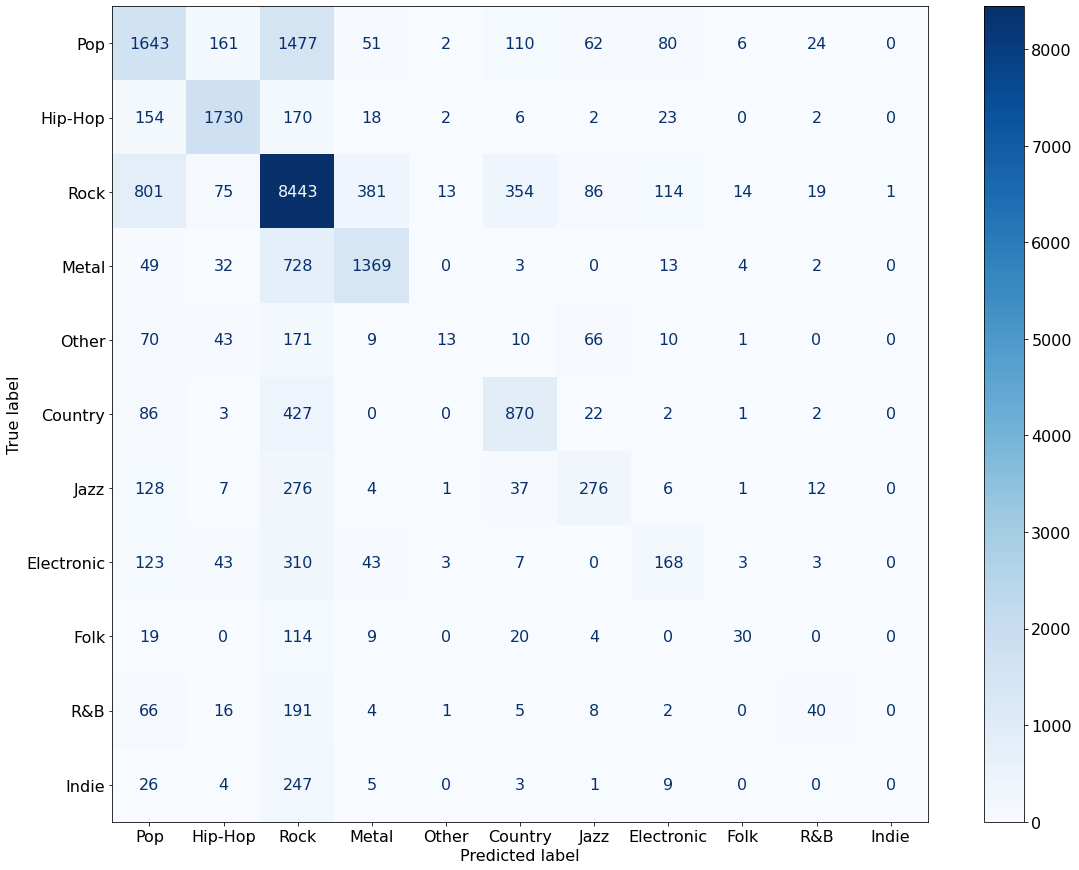

In [ ]:
# confusion matrix

confusion_mat(predictions, true_test_labels)